In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pickle
from matplotlib.cm import coolwarm
from matplotlib.colors import Normalize

In [2]:
from jax.scipy.special import logsumexp

n_dim = 5

# Load the observation dictionary
with open('/Users/marchuertascompany/Documents/data/COSMOS-Web/SMF/smf_morph.pkl', 'rb') as file:
    smf_morph = pickle.load(file)






import jax.numpy as jnp

def double_schechter_function(logM, logM_star, alpha1, alpha2, logphi1, logphi2):
    M_over_M_star = logM - logM_star
    # Replace np with jnp to ensure compatibility with JAX
    return jnp.log(10) * jnp.exp(-10**M_over_M_star) * (10**M_over_M_star) * (
        10**logphi1 * 10**(M_over_M_star * alpha1) + 10**logphi2 * 10**(M_over_M_star * alpha2))





def log_prior(theta):
    logM_star, alpha1, alpha2, logphi1, logphi2 = theta
    # Create a mask that checks all conditions simultaneously
    valid = ((-5 < logphi1) & (logphi1 < 0) &
             (-5 < logphi2) & (logphi2 < 0) &
             (8.0 < logM_star) & (logM_star < 12.0) &
             (-4 < alpha1) & (alpha1 < -1) &
             (-1 < alpha2) & (alpha2 < 4))
    # Use jnp.where to handle conditions
    return jnp.where(valid, 0.0, -jnp.inf)



def log_probability(theta, data):
    lp = log_prior(theta)
    # Use jnp.where to manage the conditional check on an array of log prior values
    return jnp.where(jnp.isfinite(lp), lp + log_likelihood(theta, data), -jnp.inf)


def log_likelihood(theta, data):
    logM_star, alpha1, alpha2, logphi1, logphi2 = theta
    logM = data['data']['logM']
    Phi = data['data']['Phi']
    dPhi = data['data']['dPhi']
    
    # Assuming double_schechter_function is already defined and compatible with JAX
    model = double_schechter_function(logM, logM_star, alpha1, alpha2, logphi1, logphi2)
    residuals = Phi - model
    weighted_squared_errors = (residuals ** 2) / dPhi ** 2
    return -0.5 * jnp.sum(weighted_squared_errors)


def target_dual_moon(x, data=None):
    """
    Term 2 and 3 separate the distribution and smear it along the first and second dimension
    """
    term1 = 0.5 * ((jnp.linalg.norm(x) - 2) / 0.1) ** 2
    term2 = -0.5 * ((x[:1] + jnp.array([-3.0, 3.0])) / 0.8) ** 2
    term3 = -0.5 * ((x[1:2] + jnp.array([-3.0, 3.0])) / 0.6) ** 2
    return -(term1 - logsumexp(term2) - logsumexp(term3))

In [3]:
print(data['logM'])

NameError: name 'data' is not defined

In [4]:
n_chains = 500

rng_key, subkey = jax.random.split(jax.random.PRNGKey(42))
#initial_position = jax.random.normal(subkey, shape=(n_chains, n_dim)) * 1

initial_guess = jnp.array([10.5, -.6,-1.7, -2,-2])
# Create a random key
rng_key = jax.random.PRNGKey(42)

# Generate random Gaussian noise for perturbation
noise = jax.random.normal(rng_key, shape=(n_chains, n_dim)) * 2  # Scale of noise can be adjusted

# Create initial positions by adding noise to the initial guess
initial_positions = initial_guess + noise

In [5]:
from flowMC.nfmodel.rqSpline import MaskedCouplingRQSpline

n_dim = 5
n_layers = 4
hidden_size = [32, 32]
num_bins = 8
#data = jnp.zeros(n_dim)
rng_key, subkey = jax.random.split(rng_key)
model = MaskedCouplingRQSpline(
    n_dim, n_layers, hidden_size, num_bins, subkey
)

In [6]:
from flowMC.proposal.MALA import MALA

MALA_Sampler = MALA(log_probability, True, step_size=0.1)

In [7]:
from flowMC.Sampler import Sampler

data={}
data['logM']=smf_morph[(2.5,'all','LogMassbin')]
data['Phi']=smf_morph[(2.5,'all','Fi')]
data['dPhi']=smf_morph[(2.5,'all','dFi')]


n_loop_training = 20
n_loop_production = 20
n_local_steps = 100
n_global_steps = 10
num_epochs = 50

learning_rate = 0.005
momentum = 0.9
batch_size = 10000
max_samples = 10000



rng_key, subkey = jax.random.split(rng_key)
nf_sampler = Sampler(
    n_dim,
    subkey,
    {'data': data},
    MALA_Sampler,
    model,
    n_loop_training=n_loop_training,
    n_loop_production=n_loop_production,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    batch_size=batch_size,
    use_global=True,
)

['n_dim', 'n_chains', 'n_local_steps', 'n_global_steps', 'n_loop', 'output_thinning', 'verbose']


In [9]:
nf_sampler.sample(initial_positions, data={'data':data})

Global Tuning:   0%|          | 0/20 [00:00<?, ?it/s]

Compiling MALA body


Global Sampling: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]


In [8]:
data['logM']

array([ 7.15231,  7.45231,  7.75231,  8.05231,  8.35231,  8.65231,
        8.95231,  9.25231,  9.55231,  9.85231, 10.15231, 10.45231,
       10.75231, 11.05231, 11.35231, 11.65231, 11.95231])

In [10]:
out_train = nf_sampler.get_sampler_state(training=True)
print("Logged during tuning:", out_train.keys())

Logged during tuning: dict_keys(['chains', 'log_prob', 'local_accs', 'global_accs', 'loss_vals'])


In [11]:
import corner
import matplotlib.pyplot as plt

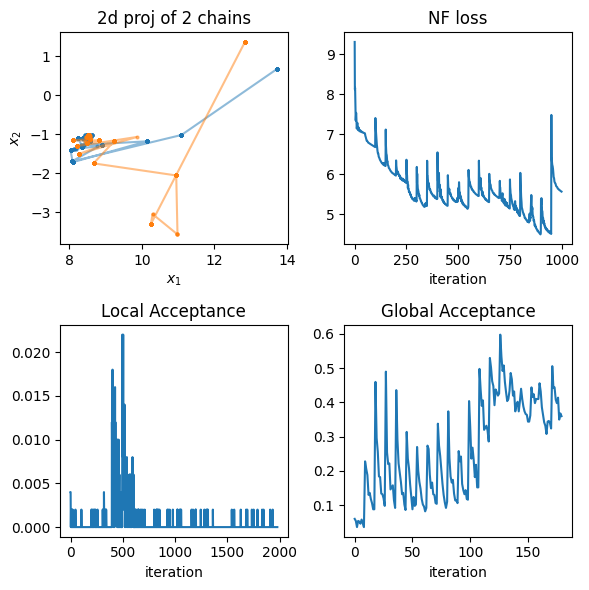

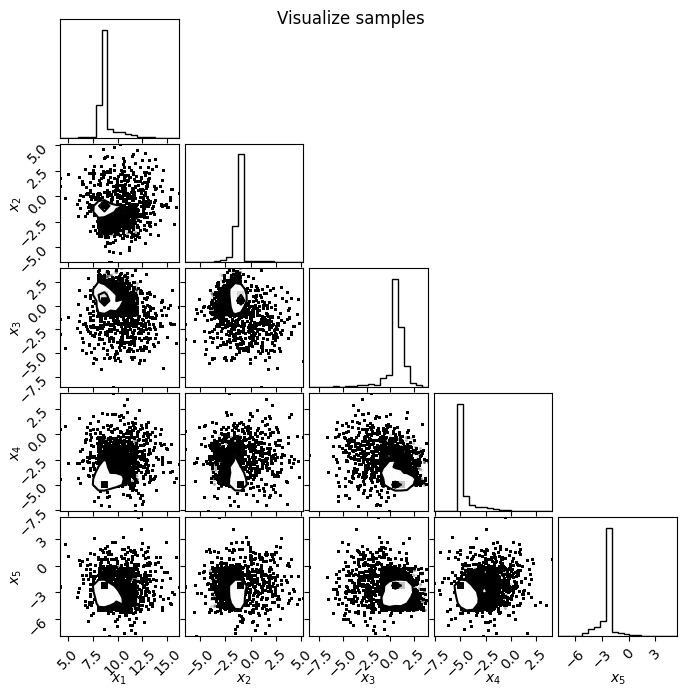

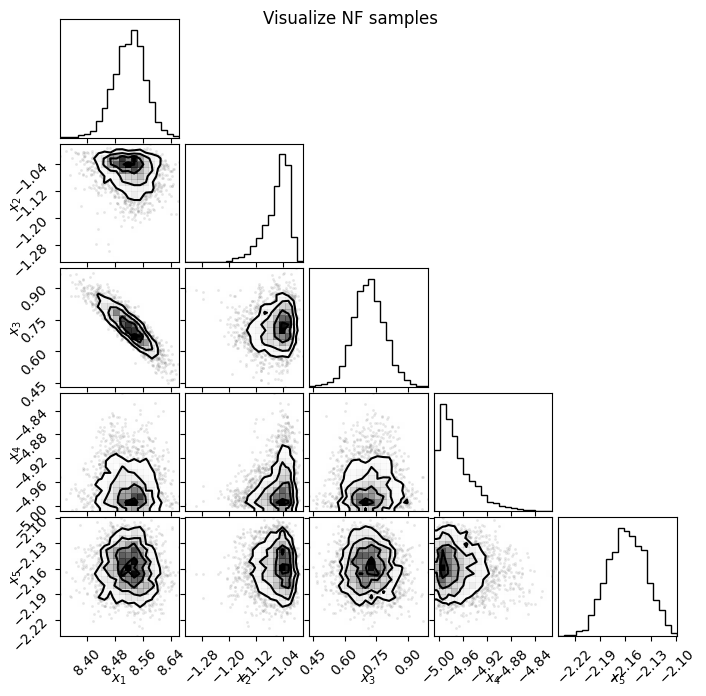

In [12]:
chains = np.array(out_train["chains"])
global_accs = np.array(out_train["global_accs"])
local_accs = np.array(out_train["local_accs"])
loss_vals = np.array(out_train["loss_vals"])
rng_key, subkey = jax.random.split(rng_key)
nf_samples = np.array(nf_sampler.sample_flow(subkey, 3000))


# Plot 2 chains in the plane of 2 coordinates for first visual check
plt.figure(figsize=(6, 6))
axs = [plt.subplot(2, 2, i + 1) for i in range(4)]
plt.sca(axs[0])
plt.title("2d proj of 2 chains")

plt.plot(chains[0, :, 0], chains[0, :, 1], "o-", alpha=0.5, ms=2)
plt.plot(chains[1, :, 0], chains[1, :, 1], "o-", alpha=0.5, ms=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("NF loss")
plt.plot(loss_vals.reshape(-1))
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[3])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")
plt.tight_layout()
plt.show(block=False)

labels = ["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]
# Plot all chains
figure = corner.corner(chains.reshape(-1, n_dim), labels=labels)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")
plt.show(block=False)

# Plot Nf samples
figure = corner.corner(nf_samples, labels=labels)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize NF samples")
plt.show()

In [13]:
parameter_means = np.mean(chains, axis=(0, 1))

print("Means of the posterior samples for each parameter:")
print(parameter_means)


Means of the posterior samples for each parameter:
[ 8.789365   -1.16975     0.63540626 -4.472177   -2.4114544 ]


/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_58132/2133945645.py:4: RuntimeWarning: invalid value encountered in log10
  lower_errors = np.log10(data['Phi']) - np.log10(data['Phi'] - data['dPhi'])
/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_58132/2133945645.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.plot(data['logM'], np.log10(double_schechter_function(data['logM'], parameter_means[0], parameter_means[1], parameter_means[2], parameter_means[3], parameter_means[4])))


(-8.0, 0.0)

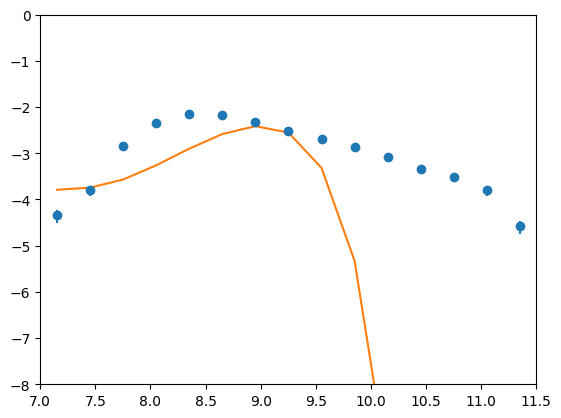

In [14]:
#print(logM_star_mcmc,alpha1_mcmc, alpha2_mcmc,logphi1_mcmc,logphi2_mcmc)

upper_errors = np.log10(data['Phi'] + data['dPhi']) - np.log10(data['Phi'])
lower_errors = np.log10(data['Phi']) - np.log10(data['Phi'] - data['dPhi'])

# Prepare error array for plotting in matplotlib
errors = [lower_errors, upper_errors]

plt.errorbar(data['logM'], np.log10(data['Phi']), yerr=errors, fmt='o',label='Data')

plt.plot(data['logM'], np.log10(double_schechter_function(data['logM'], parameter_means[0], parameter_means[1], parameter_means[2], parameter_means[3], parameter_means[4])))

plt.xlim((7,11.5))
plt.ylim(-8,0)